In [2]:
pip install librosa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 8.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.2/26.2 MB 2.6 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 2.7 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install tqdm


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [23]:
pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 4.9 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 2.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 2.7 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [12]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm

audio_path = 'ESC-50-master/audio/'
meta_path = 'ESC-50-master/meta/esc50.csv'

meta_data = pd.read_csv(meta_path)

# Parameter untuk Mel-spectrogram
SAMPLE_RATE = 22050
DURATION = 5  # durasi klip audio dalam detik
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
N_MELS = 128

def extract_mel_spectrogram(file_path):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
    if len(y) < SAMPLES_PER_TRACK:
        padding = SAMPLES_PER_TRACK - len(y)
        y = np.pad(y, (0, padding), 'constant')
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db


In [13]:
import cv2
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Inisialisasi list untuk data dan label
X = []
y = []

# Loop melalui setiap file audio dan ekstrak Mel-spectrogram
for index, row in tqdm(meta_data.iterrows(), total=meta_data.shape[0]):
    file_name = row['filename']
    file_path = os.path.join(audio_path, file_name)
    label = row['category']
    
    mel_spec = extract_mel_spectrogram(file_path)
    
    # Normalisasi dan konversi ke format RGB
    mel_spec_norm = cv2.normalize(mel_spec, None, 0, 255, cv2.NORM_MINMAX)
    mel_spec_norm = mel_spec_norm.astype(np.uint8)
    mel_spec_rgb = cv2.cvtColor(mel_spec_norm, cv2.COLOR_GRAY2RGB)
    mel_spec_resized = cv2.resize(mel_spec_rgb, (224, 224))
    
    X.append(mel_spec_resized)
    y.append(label)

# Konversi list ke array numpy
X = np.array(X)
y = np.array(y)

# Encode label menjadi angka
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)


100%|██████████████████████████████████████| 2000/2000 [00:14<00:00, 136.52it/s]


In [27]:
import numpy as np
import random
import cv2
import tensorflow as tf
from tensorflow.image import rot90, flip_left_right, flip_up_down

# List baru untuk menyimpan data augmentasi
X_augmented = []
y_augmented = []

# Fungsi augmentasi sederhana untuk gambar Mel-spectrogram (2000 ke 6000)
def augment_image(image):
    ops = [
        lambda x: flip_left_right(x),
        lambda x: flip_up_down(x),
        lambda x: rot90(x, k=1),
        lambda x: cv2.GaussianBlur(x.numpy(), (3, 3), 0),  # convert TF tensor to NumPy
    ]
    op = random.choice(ops)
    augmented = op(tf.convert_to_tensor(image)) if callable(op) else image
    return augmented.numpy() if hasattr(augmented, 'numpy') else augmented

for i in range(len(X)):
    X_augmented.append(X[i])
    y_augmented.append(y_categorical[i])

    for _ in range(2):  
        aug_img = augment_image(X[i])
        X_augmented.append(aug_img)
        y_augmented.append(y_categorical[i])

# Konversi ke array numpy
X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

print(f"Jumlah data setelah augmentasi: {X_augmented.shape[0]}")


Jumlah data setelah augmentasi: 6000


In [ ]:
# --- AUGMENTATION FUNCTIONS ---

# def add_noise(data, noise_factor=0.005):
#     noise = np.random.randn(len(data))
#     augmented = data + noise_factor * noise
#     return np.clip(augmented, -1.0, 1.0)

# def time_stretch(data, rate=1.1):
#     return librosa.effects.time_stretch(data, rate)

# def pitch_shift(data, sr, n_steps=2):
#     return librosa.effects.pitch_shift(data, sr=sr, n_steps=n_steps)

# def time_shift(data, shift_max=0.2):
#     shift = np.random.randint(int(len(data) * shift_max))
#     return np.roll(data, shift)

In [ ]:
# --- LOAD + AUGMENT ---

# def load_and_augment(file_path, sr=22050, duration=5):
#     signal, _ = librosa.load(file_path, sr=sr, duration=duration)
#     if len(signal) < sr * duration:
#         signal = np.pad(signal, (0, sr * duration - len(signal)))

#     # Original + 2 augments
#     augments = [signal]

#     # 2 random augmentations
#     funcs = [add_noise, time_stretch, pitch_shift, time_shift]
#     random_funcs = random.sample(funcs, 2)

#     for func in random_funcs:
#         if func == pitch_shift:
#             augmented = func(signal, sr=sr)
#         elif func == time_stretch:
#             try:
#                 augmented = func(signal, rate=random.uniform(0.8, 1.2))
#             except:
#                 augmented = signal
#         else:
#             augmented = func(signal)
#         augments.append(augmented)

#     return augments

# # --- APPLY TO WHOLE DATASET ---

# X_aug, y_aug = [], []

# for i, row in tqdm(df.iterrows(), total=len(df)):
#     label = row["target"]
#     file_path = os.path.join(data_dir, row["filename"])
    
#     samples = load_and_augment(file_path)

#     for s in samples:
#         mel = librosa.feature.melspectrogram(y=s, sr=22050, n_mels=128)
#         mel_db = librosa.power_to_db(mel, ref=np.max)
#         mel_db = mel_db.astype(np.float32)
#         mel_db = np.expand_dims(mel_db, axis=-1)
#         mel_db = tf.image.resize(mel_db, [224, 224]).numpy()

#         X_aug.append(mel_db)
#         y_aug.append(label)

# # Convert ke numpy array & one-hot label
# X_aug = np.array(X_aug)
# y_aug = to_categorical(np.array(y_aug), num_classes=50)

# print(f"Dataset selesai: {X_aug.shape} (seharusnya 3x dari original)")


In [36]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=42, stratify=y_augmented)

X_train = X_train / 255.0
X_test = X_test / 255.0

In [55]:
# Model
base_model = MobileNetV2(weights=None, include_top=False, input_shape=(224, 224, 3))
base_model.load_weights('mobilenet_v2_no_top.h5')

for layer in base_model.layers:
    layer.trainable = False
    
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(50, activation='softmax')(x)
model = Model(inputs, outputs)


In [56]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,              # berhenti setelah 5 epoch tanpa peningkatan
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)


In [60]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), 
    callbacks=[early_stop, checkpoint])

for layer in base_model.layers[-30:]:  # 30 layer terakhir
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), 
    callbacks=[early_stop, checkpoint])


In [63]:
from tensorflow.keras.models import load_model

model = load_model("best_model.keras")

In [65]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), 
    callbacks=[early_stop, checkpoint])

Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.7493 - loss: 0.9114
Epoch 1: val_accuracy improved from -inf to 0.68833, saving model to best_model.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.7493 - loss: 0.9113 - val_accuracy: 0.6883 - val_loss: 1.0734
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.7897 - loss: 0.7938
Epoch 2: val_accuracy improved from 0.68833 to 0.70583, saving model to best_model.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 50s 336ms/step - accuracy: 0.7897 - loss: 0.7938 - val_accuracy: 0.7058 - val_loss: 1.0275
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.8035 - loss: 0.7163
Epoch 3: val_accuracy improved from 0.70583 to 0.71917, saving model to best_model.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 55s 370ms/step - accuracy: 0.8035 - loss: 0.7163 - val_accuracy: 0.7192 - val_loss: 0.9817
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.8214 - loss: 0.6517
Epoch 4: val_accuracy im

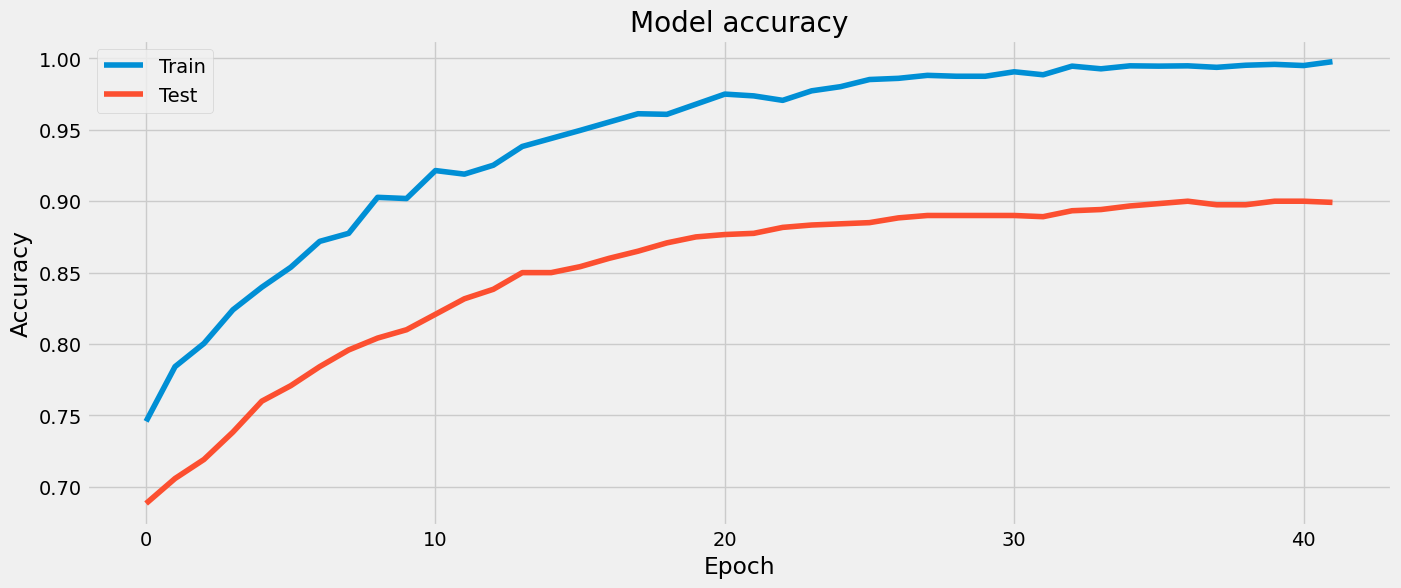

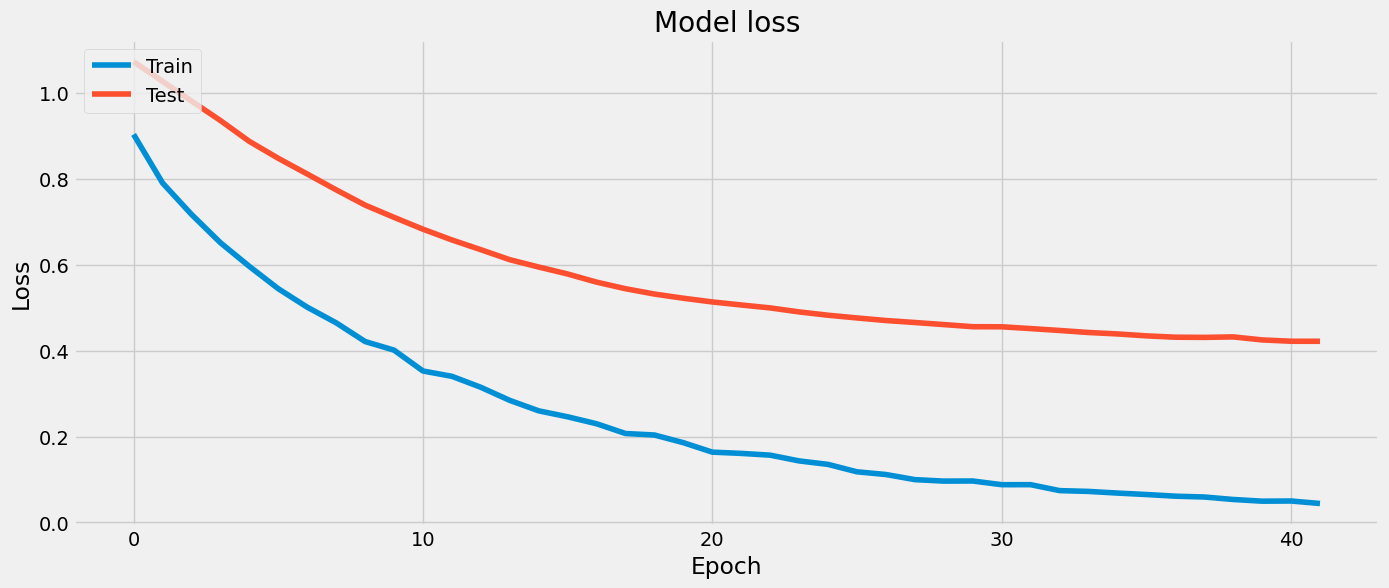

In [66]:
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
# Plot training & validation accuracy values
plt.figure(figsize=(15,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [67]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - accuracy: 0.8957 - loss: 0.4426
Test Accuracy: 90.00%


In [70]:
y_pred = model.predict(X_test)

38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 208ms/step


In [72]:
from sklearn.metrics import classification_report

# Pastikan y_pred adalah label (bukan probabilitas)
y_pred_labels = np.argmax(y_pred, axis=1)

# Label ground truth
y_true = np.argmax(y_test, axis=1)

target_names = meta_data['category'].unique()  

print(classification_report(y_true, y_pred_labels, target_names=target_names))

                  precision    recall  f1-score   support

             dog       0.84      0.88      0.86        24
  chirping_birds       0.76      0.79      0.78        24
  vacuum_cleaner       1.00      0.79      0.88        24
    thunderstorm       0.67      0.75      0.71        24
 door_wood_knock       0.95      0.88      0.91        24
     can_opening       0.96      0.92      0.94        24
            crow       0.96      0.92      0.94        24
        clapping       0.88      0.96      0.92        24
       fireworks       0.96      1.00      0.98        24
        chainsaw       0.95      0.88      0.91        24
        airplane       0.95      0.83      0.89        24
     mouse_click       0.96      1.00      0.98        24
   pouring_water       0.78      0.88      0.82        24
           train       0.96      0.96      0.96        24
           sheep       0.88      0.96      0.92        24
     water_drops       1.00      0.92      0.96        24
    church_be

<Axes: >

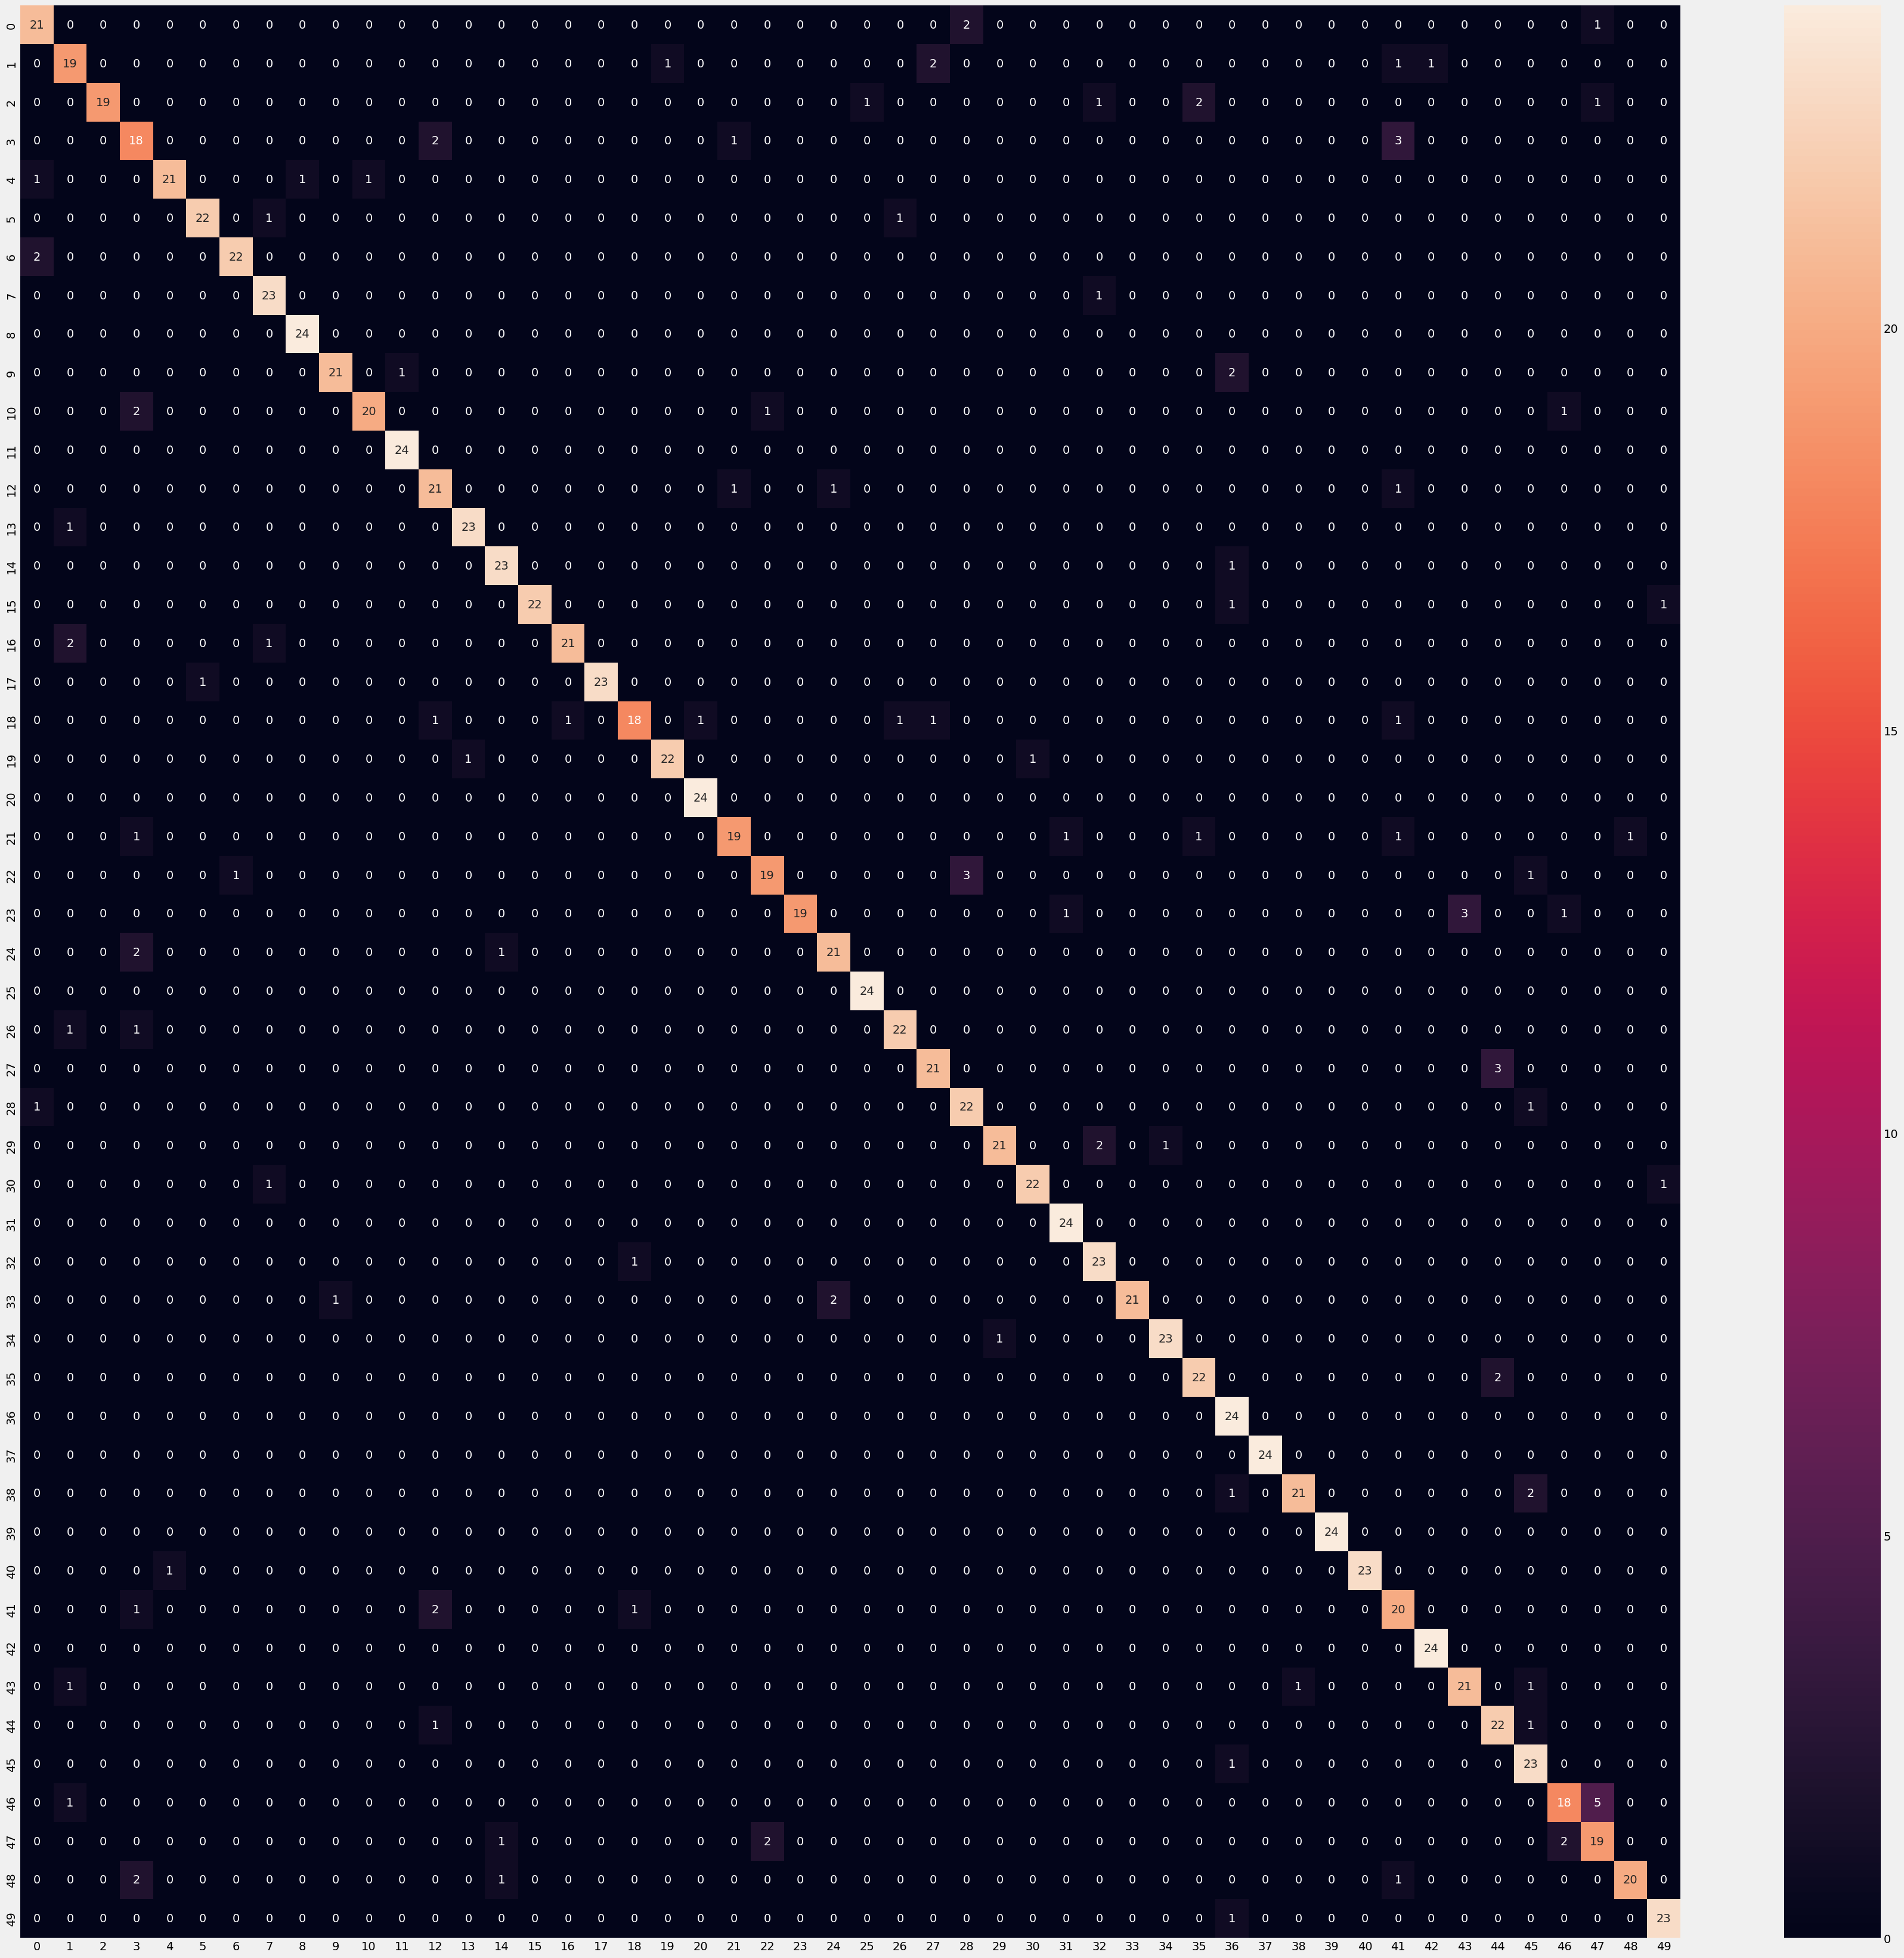

In [75]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Buat confusion matrix
cn_matrix = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize = (40,40))
sns.heatmap(cn_matrix, fmt='d', annot=True)

In [68]:
# model.save('ESC50MobileNet.keras')